<a href="https://colab.research.google.com/github/caindy/mml/blob/main/07.1_recurrent_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [7]:
actual = 'LRZ1 ActualLoad (MWh)'
features = ['MSP', 'DayOfYear', 'HourEnding', 'IsBusinessHour', actual]

import pandas as pd
df = pd.read_parquet('zone1.parquet')
df[actual] = df[actual] / 100
raw_data = df.to_numpy()
load = df[actual].to_numpy()

# 50/25/25 split. Probably need a different approach to validate over a year.
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
#raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras

# our input sequence will be seven days of hourly observations
sampling_rate = 1
sequence_length = 72 #24*7

# delay to ensure our predictions don't use intraday information
# we start with 24 hours out
delay = sampling_rate * (sequence_length + 24 - 1) 

batch_size = 32 # hyperparameter
should_shuffle = True

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [9]:
def evaluate(model, epochs=10):
    callbacks = [keras.callbacks.ModelCheckpoint("naive_lstm.keras", save_best_only=True)]
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model("naive_lstm.keras")
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history

from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

In [13]:
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
history = evaluate(model, epochs=10)

Epoch 1/10
979/979 [==============================] - 89s 44ms/step - loss: 5742.3052 - mae: 72.0905 - val_loss: 2224.5205 - val_mae: 44.4380
Epoch 2/10
979/979 [==============================] - 43s 44ms/step - loss: 1163.8546 - mae: 29.0879 - val_loss: 401.3479 - val_mae: 16.2285
Epoch 3/10
979/979 [==============================] - 43s 43ms/step - loss: 298.4802 - mae: 13.2632 - val_loss: 131.6078 - val_mae: 8.5827
Epoch 4/10
979/979 [==============================] - 43s 43ms/step - loss: 126.3115 - mae: 8.1357 - val_loss: 78.9872 - val_mae: 6.6961
Epoch 5/10
979/979 [==============================] - 42s 43ms/step - loss: 83.4846 - mae: 6.6845 - val_loss: 64.6225 - val_mae: 6.0969
Epoch 6/10
979/979 [==============================] - 43s 43ms/step - loss: 70.6546 - mae: 6.2527 - val_loss: 58.6984 - val_mae: 5.9013
Epoch 7/10
979/979 [==============================] - 43s 44ms/step - loss: 63.1381 - mae: 5.9640 - val_loss: 66.2287 - val_mae: 6.3066
Epoch 8/10
979/979 [=============

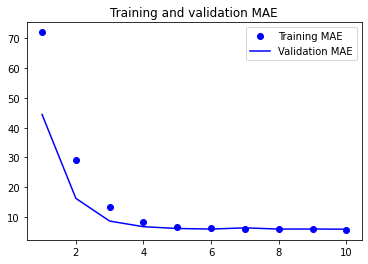

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Let's evaluate our trained model against recent data.